# HW3: Hidden Markov Models

STATS305B, Stanford University, Winter 2025

**Your name:**

**Collaborators:**

**Hours spent:**

-----

This assignment will focus on latent variable models for spatiotemporal data. Here, our focus is on climate data, analyzing long-term trends in global temperature.

* **Data**: Mean temperature in the lower troposphere from [NOAA](https://www.ncei.noaa.gov/products/climate-data-records/mean-layer-temperature-noaa). The data is sampled monthly from 1981 to 2024, and it has global coverage on a 2.5° $\times$ 2.5° grid.
* **Model**: We will use **Hidden Markov Models (HMMs)** to look for anomalies in global temperature trends.
* **Algorithm**: We'll fit the model using **Expectation-Maximization (EM)** and the **forward-backward algorithm**.

## Setup

In [1]:
%%capture
%pip install jaxtyping
%pip install basemap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from datetime import datetime
from jaxtyping import Float, Bool
from torch import Tensor
from torch.distributions import Normal
from tqdm.auto import trange
from typing import Optional, Tuple

### Load the data

This dataset was downloaded from [NOAA](https://www.ncei.noaa.gov/products/climate-data-records/mean-layer-temperature-noaa). It consists of the following fields:
- `temperature`: a Tensor of shape $T \times D_{\mathsf{lat}} \times D_{\mathsf{lon}}$ where
    - $T$ denotes the number of timesteps,
    - $D_{\mathsf{lat}}$ specifies the number of latitudes grid points, and
    - $D_{\mathsf{lon}}$ specifies the number of longitude grid points.

  Note that the temperature is measured in [degrees Kelvin](https://en.wikipedia.org/wiki/Kelvin) and it represents the average temperature in the [lower troposphere](https://www.noaa.gov/jetstream/atmosphere/layers-of-atmosphere), which extends up to 6-20km from the Earth's surface. The reported temperature is the mean temperature for the corresponding month.

- `latitude`: Tensor of shape $(D_{\mathsf{lat}}+1) \times (D_{\mathsf{lon}}+1)$ with a latitude for the edges of each bin in the grid
- `longitude`: Tensor of shape $(D_{\mathsf{lat}}+1) \times (D_{\mathsf{lon}}+1)$ with a longitude for the edges of each bin in the grid
- `dates`: Numpy array of shape $T$ and dtype `datetime64` containing the date of each measurement.

We performed some light preprocessing to make the data easier to work with. Specifically, we:
- Extracted the data from the original netCDF4 format and converted it into PyTorch tensors.
- Dropped missing data for the poles ($|\mathrm{latitude}| >82.5$).
- Created a meshgrid of latitude and longitude for plotting.
- Created a numpy array of dates for the time series.


In [3]:
# Download the data
!wget -nc https://github.com/slinderman/stats305b/raw/refs/heads/winter2025/assignments/hw3/hw3.pt

File ‘hw3.pt’ already there; not retrieving.



In [4]:
hw3_dataset = torch.load('hw3.pt', weights_only=False)
temperature = hw3_dataset['temperature']
latitude = hw3_dataset['latitude']
longitude = hw3_dataset['longitude']
dates = hw3_dataset['dates']

### Helper function for plotting

In [5]:
def plot_temperature(data : Float[Tensor, "n_latitude n_longitude"],
                     lats : Float[Tensor, "n_latitude n_longitude"],
                     lons : Float[Tensor, "n_latitude n_longitude"],
                     title : Optional[str]=None,
                     cmap : Optional[np.array]=sns.color_palette("icefire", as_cmap=True),
                     ax: Optional[plt.Axes]=None,
                     **kwargs) -> None:
    """
    Plot the temperature data using Basemap.

    Parameters
    ----------
    data : Float[Tensor, "n_latitude n_longitude"]
        The temperature data to plot.

    lats : Float[Tensor, "n_latitude n_longitude"]
        A meshgrid of latitudes

    lons : Float[Tensor, "n_latitude n_longitude"]
        A meshgrid of longitudes

    title : Optional[str]
        The title of the plot

    cmap : Optional[np.Array]
        The colormap to use for the plot

    ax : Optional[plt.Axes]
        The axes to plot on

    **kwargs:
        Additional arguments to pass to the Basemap `pcolormesh` function.
        For example, you may want to set the `vmin` and `vmax` values for the colormap.
    """
    try:
        from mpl_toolkits.basemap import Basemap
    except:
        print("Basemap is not installed, but it is not strictly required for this assignment. " \
              "If you'd like to generate this plot, try running `conda install basemap` " \
              " or `pip install basemap`. Note that basemap is not currently working in "\
              "Python 3.13.")
        return

    # create figure, axes instances.
    if ax is None:
        fig = plt.figure()
        ax = fig.add_axes([0.05,0.05,0.9,0.9])

    # create Basemap instance.
    m = Basemap(projection='mill',
                llcrnrlon=-180,
                llcrnrlat=-82.5,
                urcrnrlon=180,
                urcrnrlat=82.5,
                ax=ax)

    # draw boundarie and coasts
    m.drawmapboundary(fill_color='0.8')
    m.drawcoastlines(linewidth=1)

    # plot temperature as a colormap
    im = m.pcolormesh(np.array(lons),
                      np.array(lats),
                      data,
                      shading='flat',
                      cmap=cmap,
                      latlon=True,
                      **kwargs)

    # draw parallels and meridians, but don't bother labelling them.
    m.drawparallels(np.arange(-90.,90.,30.))
    m.drawmeridians(np.arange(-180.,180.,60.))
    m.colorbar(im,"bottom", size="5%", pad="2%", label="°K")
    ax.set_title(title)

You can use this function to visualize the global temperature as a heatmap.


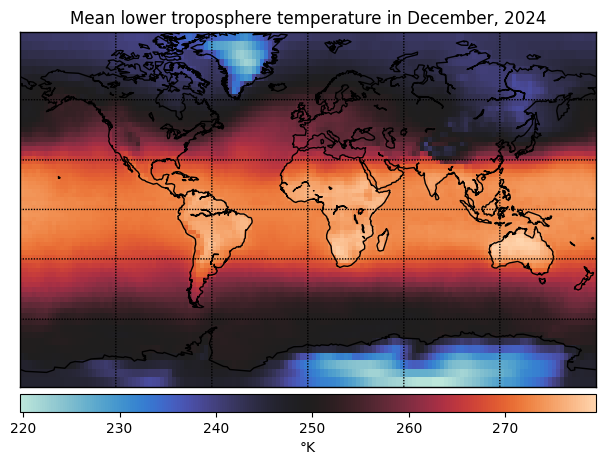

In [6]:
t = -1
date_to_str = lambda date: date.astype(datetime).strftime('%B, %Y')
plot_temperature(temperature[t], latitude, longitude,
                 title=f"Mean lower troposphere temperature in {date_to_str(dates[t])}")

### Extract global mean temperature over time

For the first part of this assignment, we will ignore the spatial component of the data and focus on the time series of global mean temperatures.

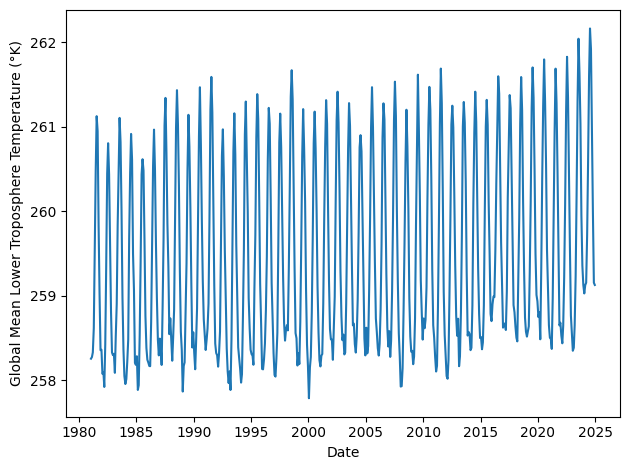

In [7]:
global_temps = temperature.mean(axis=(1,2))

plt.plot(dates, global_temps)
plt.xlabel('Date')
plt.ylabel('Global Mean Lower Troposphere Temperature (°K)')
plt.tight_layout()

You can see the trend by eye: Over the past 45 years, the global mean temperature in the lower troposphere has been rising by about 0.14 °K each decade. (The Kelvin scale is a shifted version of the Celcius scale, so this is equivalent to 0.14 °C/decade.)

In this assignment, we will model these trends and look for anomalies using hidden Markov models (HMM).

## Part 0: Establishing a Baseline

Our first step is to establish a baseline using linear regression. Let,
- $T=528$ denote the number of months of measurements in the dataset.
- $y_t \in \mathbb{R}$ denote the global mean temperature in month $t=1,\ldots,T$.
- $d_t \in \{1,\ldots,12\}$ denote which month the measurement was made in.

### Problem 0a: Fit a linear model

Compute $\hat{\boldsymbol{\beta}}_{\mathsf{MLE}}$, the maximum likelihood estimate of the weights for a linear regression model,
\begin{align*}
y_t &= \boldsymbol{\beta}^\top \mathbf{x}_t + \epsilon_t
\end{align*}
where are assumed to be $\epsilon_t$ are independent, mean zero noise terms.

Use the following covariates,
\begin{align*}
\mathbf{x}_t = (t, \mathbb{I}[d_t = 1], \ldots, \mathbb{I}[d_t=12]) \in \mathbb{R}^{13}.
\end{align*}

In [8]:
# We'll help you extract the months as integers
months = torch.tensor([date.astype(datetime).month for date in dates])

# YOUR CODE HERE
#print(months.shape, global_temps.shape)

T = len(months)
t = torch.arange(1, T+1, dtype=torch.float32)

month_one_hot = torch.nn.functional.one_hot(months - 1, num_classes=12)
X = torch.cat([t.unsqueeze(1), month_one_hot], dim=1).float()
y = global_temps.float()
#print(X.shape, y.shape)

# MLE = OLS
beta_mle = (X.T @ X).inverse() @ X.T @ y
print(beta_mle)

tensor([1.2457e-03, 2.5805e+02, 2.5799e+02, 2.5806e+02, 2.5859e+02, 2.5951e+02,
        2.6055e+02, 2.6103e+02, 2.6066e+02, 2.5980e+02, 2.5892e+02, 2.5831e+02,
        2.5814e+02])


### Problem 0b: Plot the predictions and residuals

Plot the measurements $y$ predictions and $\hat{y}_t = \hat{\boldsymbol{\beta}}_{\mathsf{MLE}}^\top \mathbf{x}_t$.]

In a separate panel, plot the residuals $r_t \triangleq y_t - \hat{y}_t$.

Remember to label your axes!

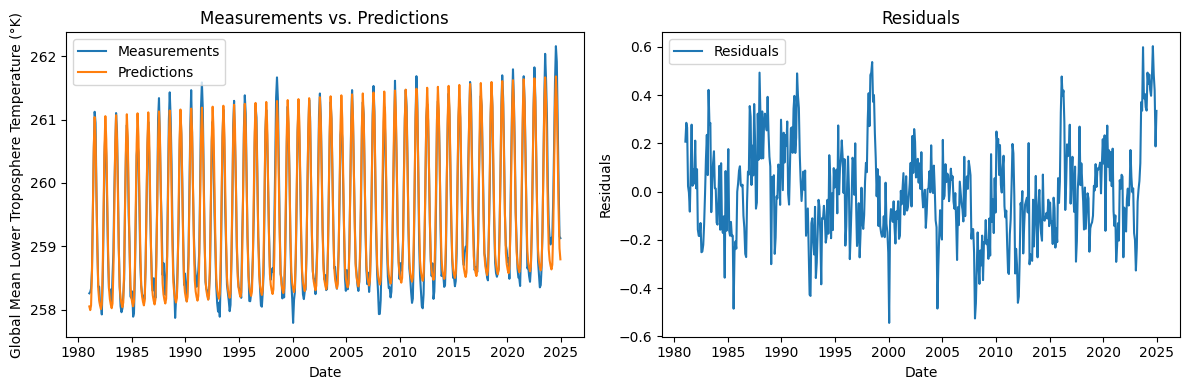

In [9]:
# YOUR CODE HERE
# Predictions
y_hat = X @ beta_mle

# Residuals
r = y - y_hat

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(dates, y, label='Measurements')
ax[0].plot(dates, y_hat, label='Predictions')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Global Mean Lower Troposphere Temperature (°K)')
ax[0].legend()
ax[0].set_title('Measurements vs. Predictions')

ax[1].plot(dates, r, label='Residuals')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Residuals')
ax[1].legend()
ax[1].set_title('Residuals')

plt.tight_layout()

### Problem 0c: Discuss

How do you interpret the estimated coefficients of this model?


_Your response here_

**Answer 0c**:

In this model, the estimated coefficients can be interpreted as:
- a linear trend (the coefficient associated with $t$)
- monthly seasonalities (coefficients associated with the month indicators)

This baseline linear regression models the global temperature as a time series with only linear trend and monthly seasonalities. The seasonalities are shared (homogenous) across different years. We can see that the predicted $y$'s nicely reflect the model behavior as they are increasingly linearly over the years and exhibit strong monthly seasonality within the year, hence the increasing stable oscillations in the plot.

Careful that we are not forcing the linear trend to be centered around the mean temperature within a year, so when interpreting the coefficients, we should look at the model all together (in monthly seasonalities, not expecting to see negative coefficients for winter months and positive coefficients for summer months).

## Part 1: State Inference with the Forward-Backward Algorithm

You should see that the residuals look autocorrelated: if $r_t$ is positive, $r_{t+1}$ is likely to be positive as well. There are several factors that could lead to such autocorrelation; one is the [El Niño Southern Oscillation (ENSO)](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation). These global variations lead to periods of warming (El Niño) and cooling (La Niña) that last around a year and occur every 2-7 years (according to Wikipedia). We will attempt to infer these events using a Hidden Markov Model (HMM).

Let $z_t \in \{1,\ldots,K\}$ denote a **discrete latent state** at time $t$. We will model the residuals as _conditionally independent_ given the latent states,
\begin{align*}
r_t \mid z_t = k &\sim \mathrm{N}(\mu_k, \sigma_k^2),
\end{align*}
where $(\mu_k, \sigma_k^2)$ denote the mean and variance of the residuals in state $k$.

We model the latent states as a Markov process,
\begin{align*}
\Pr(z_{t+1}=j \mid z_t =i) = p_{ij},
\end{align*}
where $p_{ij}$ are the elements of the transition matrix,
\begin{align*}
\mathbf{P} =
\begin{bmatrix}
p_{11} & \ldots & p_{1K} \\
\vdots & & \vdots \\
p_{K1} & \ldots & p_{KK}
\end{bmatrix}
\end{align*}

Finally, we assume
\begin{align*}
z_1 \sim \mathrm{Cat}(\boldsymbol{\pi}_0)
\end{align*}
where $\boldsymbol{\pi}_0$ is the initial distribution.

The parameters of the model are $\theta = (\{\mu_k, \sigma_k^2\}_{k=1}^K, \mathbf{P}, \boldsymbol{\pi}_0)$. Our goal is to estimate the parameters and infer the posterior marginal distributions of the latent states.


### Problem 1a: Forward-Backward Algorithm

Implement the forward-backward algorithm for computing posterior marginal probabilities,
\begin{align*}
\Pr(z_t = k \mid r_{1:T}; \theta) = \mathbb{E}[\mathbb{I}[z_t=k] \mid r_{1:T}; \theta].
\end{align*}
Also, compute the log marginal likelihood, $\log p(r_{1:T}; \theta)$, during the forward pass.

In [10]:
def forward_pass(initial_probs: Float[Tensor, "num_states"],
                 transition_matrix: Float[Tensor, "num_states num_states"],
                 log_likes: Float[Tensor, "num_timesteps num_states"]) \
                 -> Tuple[Float[Tensor, "num_timesteps num_states"], Float]:
    r"""
    Compute the filtering probabilities, $p(z_t | r_{1:t-1})$ and the marginal
    log likelihood, $\log p(r_{1:T})$, where $z_t$ is the hidden state at time $t$
    and $r_{1:t-1}$ is the observed data up to time $t-1$.

    Parameters
    ----------
    initial_probs : Float[Tensor, "num_states"]
        The initial state probabilities, $p(z_1)$.

    transition_matrix : Float[Tensor, "num_states num_states"]
        The state transition probabilities, $p(z_t | z_{t-1})$.

    log_likes : Float[Tensor, "num_timesteps num_states"]
        The log likelihoods, $\log p(r_t | z_t)$.

    Returns
    -------
    alphas : Float[Tensor, "num_timesteps num_states"]
        The filtering probabilities, $p(z_t | r_{1:t-1})$.

    marginal_loglike : Float
        The marginal log likelihood, $\log p(r_{1:T})$.

    """
    # YOUR CODE HERE
    T, K = log_likes.shape
    alphas = torch.zeros((T, K))
    unnormalized_alpha_0 = initial_probs * torch.exp(log_likes[0]) # diff. init if fix
    alphas[0] = unnormalized_alpha_0 / torch.sum(unnormalized_alpha_0)
    marginal_loglike = torch.log(torch.sum(unnormalized_alpha_0))

    for t in range(1, T):
      # unnormalized_alpha_t = transition_matrix.T @ (alphas[t-1] * torch.exp(log_likes[t-1])) # this requires fix
      unnormalized_alpha_t = transition_matrix.T @ alphas[t-1] * torch.exp(log_likes[t]) # OK
      #unnormalized_alpha_t = alphas[t-1].matmul(transition_matrix) * torch.exp(log_likes[t])
      alphas[t] = unnormalized_alpha_t / torch.sum(unnormalized_alpha_t)
      marginal_loglike += torch.log(torch.sum(unnormalized_alpha_t))

    #print(alphas)
    return alphas, marginal_loglike


def backward_pass(transition_matrix: Float[Tensor, "num_states num_states"],
                  log_likes: Float[Tensor, "num_timesteps num_states"]) \
                  -> Float[Tensor, "num_timesteps num_states"]:
    r"""
    Compute the backward probabilities, $\beta_t \propto p(z_t, r_{t+1:T})$

    Parameters
    ----------
    transition_matrix : Float[Tensor, "num_states num_states"]
        The state transition probabilities, $p(z_t | z_{t-1})$.

    log_likes : Float[Tensor, "num_timesteps num_states"]
        The log likelihoods, $\log p(r_t | z_t)$.

    Returns
    -------
    betas : Float[Tensor, "num_timesteps num_states"]
        The backward probabilities, $\beta_t \propto p(z_t, r_{t+1:T})$.

    """
    # YOUR CODE HERE
    T, K = log_likes.shape
    betas = torch.zeros((T, K))
    betas[-1] = torch.ones(K)
    for t in range(T-2, -1, -1):
      unnormalized_beta_t = transition_matrix @ (betas[t+1] * torch.exp(log_likes[t+1])) # OK
      #unnormalized_beta_t = transition_matrix.matmul(torch.exp(log_likes[t+1]) * betas[t+1])
      betas[t] = unnormalized_beta_t / torch.sum(unnormalized_beta_t)
    #print(betas)
    return betas


def forward_backward(initial_probs: Float[Tensor, "num_states"],
                     transition_matrix: Float[Tensor, "num_states num_states"],
                     log_likes: Float[Tensor, "num_timesteps num_states"]) \
                     -> Tuple[Float[Tensor, "num_timesteps num_states"], Float]:
    r""" Run the forward backward algorithm to compute the posterior expected states,
    $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$, and the marginal log likelihood,
    $\log p(r_{1:T})$.

    Parameters
    ----------
    initial_probs : Float[Tensor, "num_states"]
        The initial state probabilities, $p(z_1)$.

    transition_matrix : Float[Tensor, "num_states num_states"]
        The state transition probabilities, $p(z_t | z_{t-1})$.

    log_likes : Float[Tensor, "num_timesteps num_states"]
        The log likelihoods, $\log p(r_t | z_t)$.

    Returns
    -------
    expected_states : Float[Tensor, "num_timesteps num_states"]
        The expected states, $Pr(z_t=k | r_{1:t-1})$ for all $t$ and $k$.

    marginal_loglike : Float
        The marginal log likelihood, $\log p(r_{1:T})$.
    """
    # YOUR CODE HERE
    alphas, marginal_loglike = forward_pass(initial_probs, transition_matrix, log_likes)
    betas = backward_pass(transition_matrix, log_likes)
    unnormalized_product = alphas * betas
    normalized_product = unnormalized_product / torch.sum(unnormalized_product, dim=1, keepdim=True)
    expected_states = normalized_product
    return expected_states, marginal_loglike

#### Test Case
Compare to exact computations for a small model with $K=2$ states and $T=3$ timesteps.

_Note: This test is necessary but not sufficient to ensure that your code is correct and stable!_

In [11]:
def test_1a():
    torch.manual_seed(305 + ord('b'))
    initial_probs = torch.ones(2) / 2
    transition_matrix = torch.eye(2) * 0.9 + (1 - torch.eye(2)) * 0.1
    log_likes = torch.randn(3, 2)

    # Run your code
    expected_states, marginal_loglike = forward_backward(initial_probs, transition_matrix, log_likes)

    # Compute the log joint probs explicitly
    log_joint_probs = torch.zeros(2, 2, 2)
    for z1 in range(2):
        for z2 in range(2):
            for z3 in range(2):
                log_joint_probs[z1, z2, z3] = \
                    torch.log(initial_probs[z1]) + \
                    torch.log(transition_matrix[z1, z2]) + \
                    torch.log(transition_matrix[z2, z3]) + \
                    log_likes[0, z1] + \
                    log_likes[1, z2] + \
                    log_likes[2, z3]

    # Compare the marginal log likelihood
    marginal_loglike_explicit = torch.logsumexp(log_joint_probs, dim=(0, 1, 2))
    assert torch.allclose(marginal_loglike, marginal_loglike_explicit)

    # Compare the posterior marginal probabilities
    posterior_probs = torch.exp(log_joint_probs - marginal_loglike_explicit)
    assert torch.allclose(expected_states[0], posterior_probs.sum(dim=(1,2)))
    assert torch.allclose(expected_states[1], posterior_probs.sum(dim=(0,2)))
    assert torch.allclose(expected_states[2], posterior_probs.sum(dim=(0,1)))


test_1a()

### Problem 1b: Compute the posterior probability of the latent states

To start, let's suppose we manually defined the following states:

1. **Neutral state** in which $\mu_1 = 0$.
2. **El Niño state** in which $\mu_2 = 0.25$.
3. **La Niña state** in which $\mu_3 = -0.25$.

In all three states, assume $\sigma_k^2 = 0.15^2$. These states correspond to the residuals being neutral, larger than average, or smaller than average, respectively.

Moreover, assume the initial distribution is uniform and the transition probabilities are $p_{kk} = \alpha$ for all $k=1,\ldots,K$ and $p_{ij} = \frac{1-\alpha}{K-1}$ for all $i\neq j$. Set $\alpha = \frac{11}{12}$ for this analysis.

You should:

1. **Compute:** the expected states (i.e., posterior marginal probabilities) using your forward-backward implementation.
2. **Print:** the marginal log likelihood of the data under these parameters.
3. **Plot:** the posterior marginal probability of being in the El Niño state over time.

For comparison, we have provided El Niño events as determined by NOAA based on sea surface temperatures. These won't align perfectly your inferences based on global mean lower tropospheric temperature, but they are still a good sanity check. Show these times on your graph as well.

_Remember to label your plots!_


In [12]:
# El Nino periods from https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
NOAA_EL_NINO_PERIODS = [
    (datetime(1982, 4, 1), datetime(1983, 6, 1)),
    (datetime(1986, 9, 1), datetime(1988, 2, 1)),
    (datetime(1991, 5, 1), datetime(1992, 6, 1)),
    (datetime(1994, 9, 1), datetime(1995, 3, 1)),
    (datetime(1997, 5, 1), datetime(1998, 5, 1)),
    (datetime(2002, 6, 1), datetime(2003, 2, 1)),
    (datetime(2004, 7, 1), datetime(2005, 2, 1)),
    (datetime(2006, 9, 1), datetime(2007, 1, 1)),
    (datetime(2009, 7, 1), datetime(2010, 3, 1)),
    (datetime(2014, 10, 1), datetime(2016, 4, 1)),
    (datetime(2018, 9, 1), datetime(2019, 6, 1)),
    (datetime(2023, 5, 1), datetime(2024, 4, 1)),
]

Marginal log likelihood of the data: tensor(215.2183)


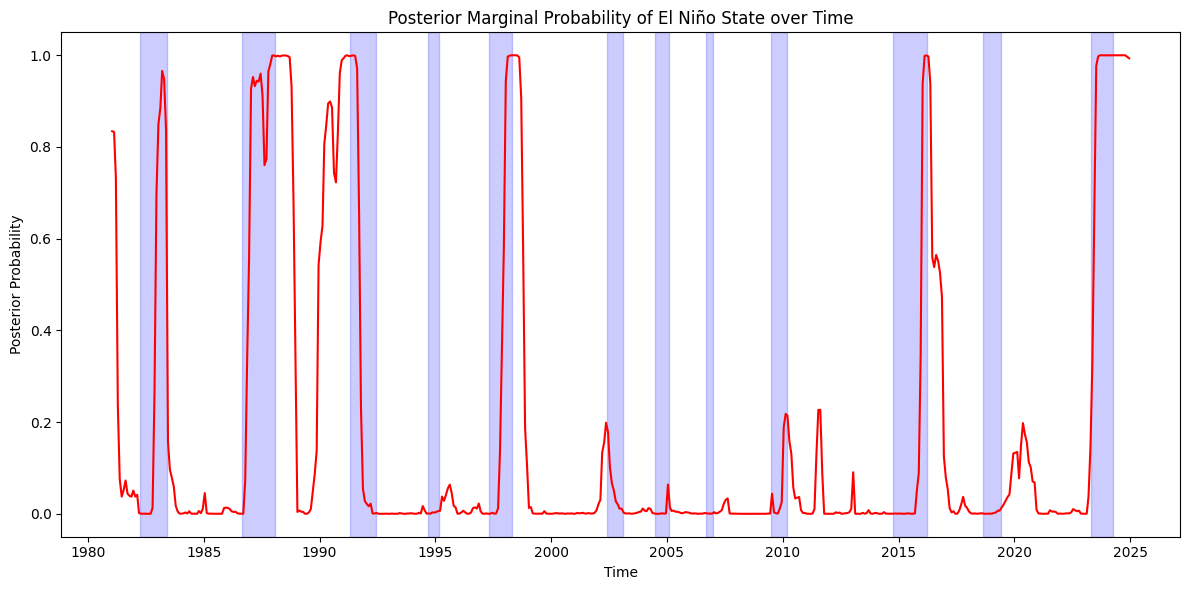

In [13]:
## YOUR CODE HERE

# Assumptions
K = 3
initial_probs = torch.tensor(np.ones(K)/K, dtype=torch.float32)
mus = torch.tensor([0.0, 0.25, -0.25])
sigma = 0.15
#print(mus.shape, mus.unsqueeze(0).shape)
normal_dist = torch.distributions.Normal(mus.unsqueeze(0), sigma)
#print(type(normal_dist))
#print(normal_dist)
#print(r.shape)
#print(r.unsqueeze(1).shape)
log_likes = normal_dist.log_prob(r.unsqueeze(1))
#print(log_likes.shape)
alpha_val = 11/12
P = np.full((K, K), (1 - alpha_val)/(K - 1))
np.fill_diagonal(P, alpha_val)
transition_matrix = torch.tensor(P, dtype=torch.float32)

# Forward Backward Algorithm
expected_states, marginal_loglike = forward_backward(initial_probs, transition_matrix, log_likes)

print("Marginal log likelihood of the data:", marginal_loglike)

# Extract El Nino Posterior
el_nino_posterior = expected_states[:, 1]
plt.figure(figsize=(12, 6))
plt.plot(dates, el_nino_posterior, label="Posterior P(El Niño state)", color='red')

# shading El Nino periods
for start, end in NOAA_EL_NINO_PERIODS:
    plt.axvspan(start, end, color='blue', alpha=0.2, label="NOAA El Niño period")

plt.xlabel("Time")
plt.ylabel("Posterior Probability")
plt.title("Posterior Marginal Probability of El Niño State over Time")
plt.tight_layout()
plt.show()

### Problem 1c: Sensitiity Analysis

Describe how your results change as you increase or decrease the _stay probability_, $\alpha$.

_Your answer here_

**Answer 1c**

When the stay probability $\alpha$ increases, the model tends to stay in the same latent state for a longer period of times, which means that the duration of the El Nino (similarly for La Nina and neutral state) state becomes longer. Thus, the results (posterior marginal probability of El Nino over time) would become more autocorrelated - if year $t$ is El Nino, then year $t+1$ is more likely to be El Nino with increased $\alpha$. Conversely, when the stay probability $\alpha$ decreases, the results become less autocorrelated. Notice that when $\alpha$ decreases to below 0.5, the results become negatively autocorrelated, which means that year $t+1$ is less likely to be El Nino given year $t$ is El Nino.

### Problem 1d: Run Length Analysis

The run length is the duration of a latent state; i.e., the number of time steps the latent state stays in state $k$ before transitioning to a new state. Under the prior with stay probability $\alpha$, how is the run length distributed? What is its expected value? Explain your findings from Problem 1c in light of the prior distribution of run lengths.

_Your answer here_

**Answer 1d**

Under the prior with stay probability $\alpha$, the run length is distributed as $\mathrm{Geom}(1 - \alpha)$ with support $\mathbb{N}^{+}$, as the length is equivalent to the waiting time until the latent state changes.

The expected value for $\mathrm{Geom}(1 - \alpha)$ with support $\mathbb{N}^{+}$ is $\frac{1}{1-\alpha}$.

Thus, with this expected value, we can see that with increased $\alpha$ (> 0.5), the expected run length becomes longer, which agrees with the findings from Problem 1c. When $\alpha = 0.5$, the expected run length is 2, and when $\alpha < 0.5$, the expected run length is less than 2, which means that the chain becomes negatively autocorrelated.

## Part 2: Parameter Estimation with EM

In Part 1 we just the eyeballed the residuals to guess appropriate means and variances. Let's be a bit more rigorous now. Here, we will fix the mean of the neutral state, $\mu_1 =0$, but we will infer the remaining means and variances $\sigma_1^2, \{\mu_k, \sigma_k^2\}_{k=2}^K$.

We'll still make a few simplifying assumptions: As before, we'll stick with $K=3$ states, a uniform initial distribution, and the same transition matrix as above with $\alpha=\frac{11}{12}$.

### Problem 2a: Derive the M-step

Derive the M-step for the emission means and variances. Let $\omega_{tk} = \Pr(z_t=k \mid r_{1:T}; \theta')$ denote the posterior marginal probabilities from the forward-backward algorithm.

_Your answer here_

**Answer 2a**


- **For the neutral state** ($ k = 1 $):

  - $ \mu_1 $ is fixed at 0.
  - $ \sigma_1^2 = \frac{\sum_{t=1}^{T} \omega_{t1} (r_t - 0)^2}{\sum_{t=1}^{T} \omega_{t1}} $

- **For states** $ k = 2, 3 $ (El Niño and La Niña):

  - $ \mu_k = \frac{\sum_{t=1}^{T} \omega_{tk} r_t}{\sum_{t=1}^{T} \omega_{tk}} $
  - $ \sigma_k^2 = \frac{\sum_{t=1}^{T} \omega_{tk} (r_t - \mu_k)^2}{\sum_{t=1}^{T} \omega_{tk}} $


### Problem 2b: Implement a Gaussian HMM

Complete the code below to implement a Gaussian HMM.

Note: This model allows for missing data to be specified by a `mask`. Mathematically, let $m_t \in \{0,1\}$ denote a mask, with $m_t=1$ indicating that $r_t$ is observed and $m_t=0$ that $r_t$ is missing. We can incorporate the mask into the model by adapting the likelihood as follows,
\begin{align*}
p(r_t \mid z_t = k, m_t; \theta) &\propto \left[\mathrm{N}(r_t \mid \mu_k, \sigma_k^2)\right]^{\mathbb{I}[m_t=1]}.
\end{align*}
Then, when $m_t=0$, the likelihood is proportional to one. Equivalently, the log likelihood goes to zero for missing timesteps.

In [14]:
class GaussianHMM:
    """An implementation of a Gaussian Hidden Markov Model and the
    Expectation-Maximization algorithm for fitting the model to data.

    This model assumes that the initial distribution and transition matrix
    are fixed. Moreover, we assume the mean of the first state is 0, as
    described above.
    """
    def __init__(self,
                 num_states : int,
                 initial_probs: Float[Tensor, "num_states"],
                 transition_matrix : Float[Tensor, "num_states num_states"],
                 initial_means : Optional[Float[Tensor, "num_states"]] = None,
                 initial_variances : Optional[Float[Tensor, "num_states"]] = None) -> None:
        self.num_states = num_states
        self.initial_probs = initial_probs
        self.transition_matrix = transition_matrix
        assert torch.allclose(transition_matrix.sum(dim=1), torch.ones(num_states))

        # Initialize the means and variances
        if initial_means is not None:
            assert initial_means.shape == (num_states,)
            self.means = initial_means
        else:
            self.means = torch.cat([torch.zeros(1), torch.randn(num_states - 1)])

        if initial_variances is not None:
            assert initial_variances.shape == (num_states,)
            self.variances = initial_variances
        else:
            self.variances = 0.15**2 * torch.ones(num_states)

    def e_step(self,
               data: Float[Tensor, "num_timesteps"],
               mask: Bool[Tensor, "num_timesteps"]) \
        -> Tuple[Float[Tensor, "num_timesteps num_states"], Float]:
        r"""Perform the E-step of EM using the forward-backward algorithm.

        Parameters
        ----------
        data : Float[Tensor, "num_timesteps"]
            The observed data.

        mask : Optional[Bool[Tensor, "num_timesteps"]]
            A boolean mask indicating which data points are observed.

        Returns
        -------
        expected_states : Float[Tensor, "num_timesteps num_states"]
            The expected states, $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$

        marginal_loglike : Float
            The marginal log likelihood, $\log p(r_{1:T})$.
        """
        # YOUR CODE HERE
        # log likelihoods
        # initialize normal distribution NOTE it takes SD instead of VAR as argument
        normal_dist = torch.distributions.Normal(self.means.unsqueeze(0), torch.sqrt(self.variances.unsqueeze(0)))
        # get likelihoods from the normal distribution and the mask
        log_likes = normal_dist.log_prob(data.unsqueeze(1)) * mask.unsqueeze(1)
        expected_states, marginal_loglike = forward_backward(self.initial_probs, self.transition_matrix, log_likes)
        return expected_states, marginal_loglike

    def m_step(self,
               data : Float[Tensor, "num_timesteps"],
               mask : Bool[Tensor, "num_timesteps"],
               expected_states: Float[Tensor, "num_timesteps num_states"]) -> None:
        r"""Perform the M-step of EM to update the model parameters.

        Note: this function should update the `means` and `variances` attributes in place,
        but the first state mean should remain fixed at 0.

        Note: Be careful to avoid division by zero if, e.g., expected states sums to 0.

        Parameters
        ----------
        data : Float[Tensor, "num_timesteps"]
            The observed data.

        mask : Optional[Bool[Tensor, "num_timesteps"]]
            A boolean mask indicating which data points are observed.

        expected_states : Float[Tensor, "num_timesteps num_states"]
            The expected states, $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$.
        """
        # YOUR CODE HERE
        # Note: Remember to fix the mean of the first state to 0

        # Convert mask to float
        mask_float = mask.float()

        # Update means
        for k in range(self.num_states):
            if k == 0:
                self.means[k] = 0.0
            else:
                weighted_sum = torch.sum(expected_states[:, k] * mask_float * data)
                weight = torch.sum(expected_states[:, k] * mask_float)
                if weight > 0:
                    self.means[k] = weighted_sum / weight
                else:
                    self.means[k] = self.means[k]

        for k in range(self.num_states):
            weighted_sq_diff = torch.sum(expected_states[:, k] * mask_float * (data - self.means[k])**2)
            weight = torch.sum(expected_states[:, k] * mask_float)
            if weight > 0:
                self.variances[k] = weighted_sq_diff / weight
            else:
                self.variances[k] = self.variances[k]
            self.variances[k] = torch.clamp(self.variances[k], min=1e-6)
        pass

    def fit(self,
            data: Float[Tensor, "num_timesteps"],
            mask: Optional[Bool[Tensor, "num_timesteps"]] = None,
            num_iters: int = 50,
            verbose: bool=True):
        """Fit the HMM with EM.

        Parameters
        ----------
        data : Float[Tensor, "num_timesteps"]
            The observed data.

        mask : Optional[Bool[Tensor, "num_timesteps"]]
            A boolean mask indicating which data points are observed.

        num_iters : int
            The number of EM iterations to run.

        verbose : bool
            Whether to print progress during training.

        Returns
        -------
        lls : Float[Tensor, "num_iters"]
            The marginal log likelihood at each iteration.

        expected_states : Float[Tensor, "num_timesteps num_states"]
            The expected states, $Pr(z_t=k | r_{1:T})$ for all $t$ and $k$.
        """
        if mask is None:
            mask = torch.ones_like(data, dtype=bool)

        lls = []
        pbar = trange(num_iters) if verbose else range(num_iters)
        for _ in pbar:
            expected_states, marginal_loglike = self.e_step(data, mask)
            self.m_step(data, mask, expected_states)
            lls.append(marginal_loglike)

        return torch.stack(lls), expected_states

Now fit your model!

In [15]:
# YOUR CODE HERE
model = GaussianHMM(num_states=3, initial_probs=initial_probs, transition_matrix=transition_matrix)
lls, expected_states = model.fit(r)

  0%|          | 0/50 [00:00<?, ?it/s]

### Problem 2c: Analysis

1. Plot the marginal log likelihood over EM iterations. (It should strictly increase!)
2. Print the estimate model means and variances.
3. Plot the residuals and the posterior probabilities for each of the $K=3$ states as a function of time.

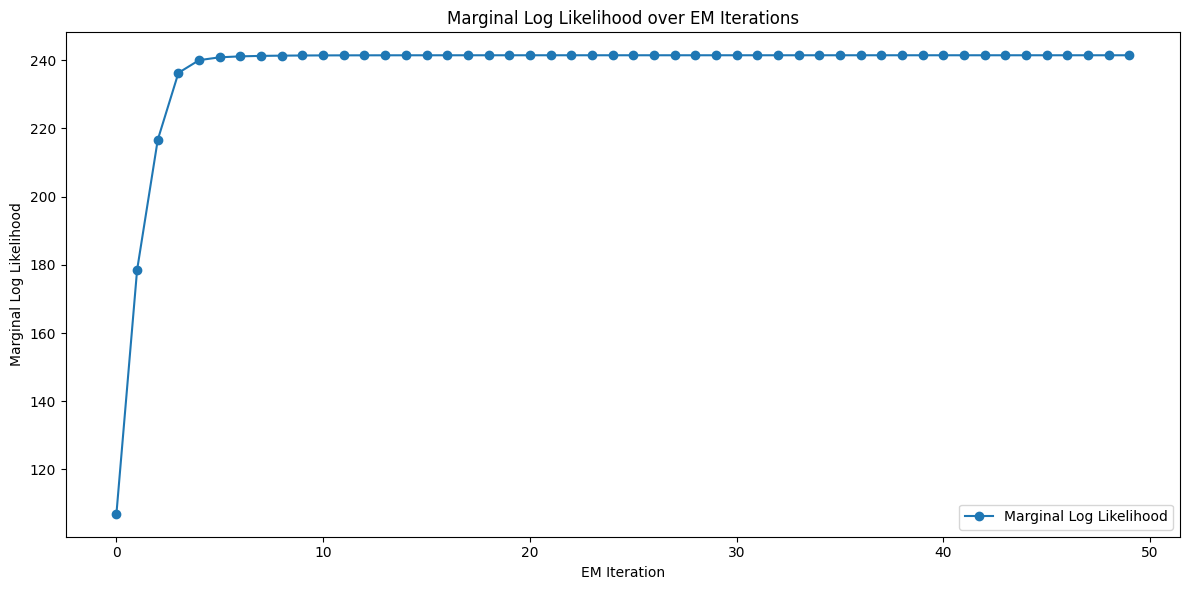

In [16]:
# YOUR CODE HERE
# Part 1 - Marginal Log Likelihood over EM Iterations
plt.figure(figsize=(12, 6))
plt.plot(lls, label="Marginal Log Likelihood", marker="o")
plt.xlabel("EM Iteration")
plt.ylabel("Marginal Log Likelihood")
plt.title("Marginal Log Likelihood over EM Iterations")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Part 2: Estimated Model
# Print means
print("Gaussian HMM Fitted Means:")
print(model.means)

# Print variances
print("\nFitted Variances:")
print(model.variances)

Gaussian HMM Fitted Means:
tensor([ 0.0000, -0.1677,  0.2634])

Fitted Variances:
tensor([0.0138, 0.0156, 0.0234])


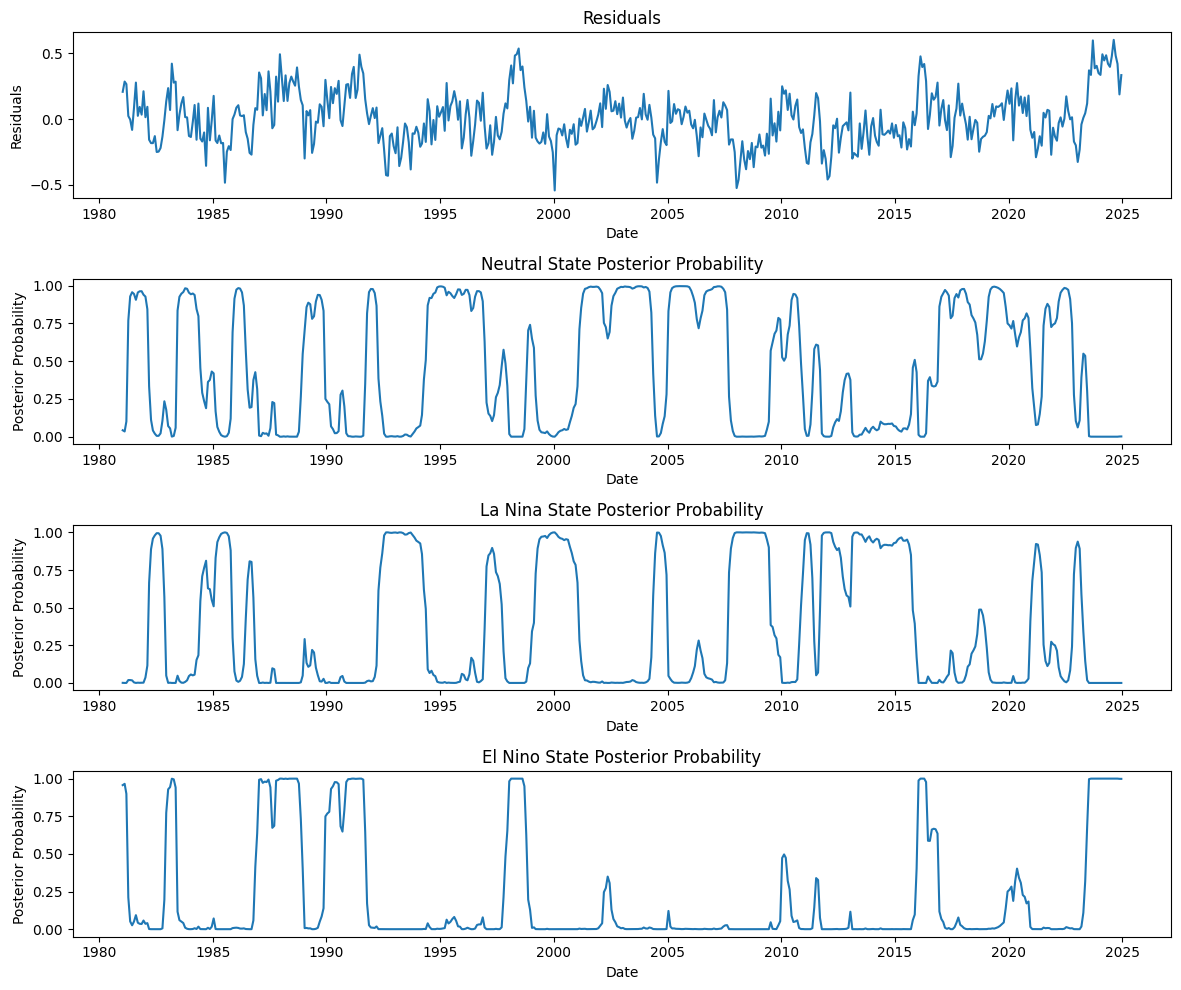

In [18]:
# Part 3: Plot residuals and estimated state probailities over time

# NOTE: Except from the neutral state where the mean is forced to be zero
# other 2 states do not have explicit ordering
# Thus, assign El Nino vs La Nina
# based on the observed fitted means.
# El Nino state should have a positive residual
# Because the global temperature is higher in El Nino state
# and conversely, La Nina state shold have a negative residual

fig, ax = plt.subplots(4, 1, figsize=(12, 10))
ax[0].plot(dates, r, label='Residuals')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

ax[1].plot(dates, expected_states[:,0], label='Neutral')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Posterior Probability')
ax[1].set_title('Neutral State Posterior Probability')

ax[2].plot(dates, expected_states[:,1], label='La Nina')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Posterior Probability')
ax[2].set_title('La Nina State Posterior Probability')

ax[3].plot(dates, expected_states[:,2], label='El Nino')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Posterior Probability')
ax[3].set_title('El Nino State Posterior Probability')

plt.tight_layout()

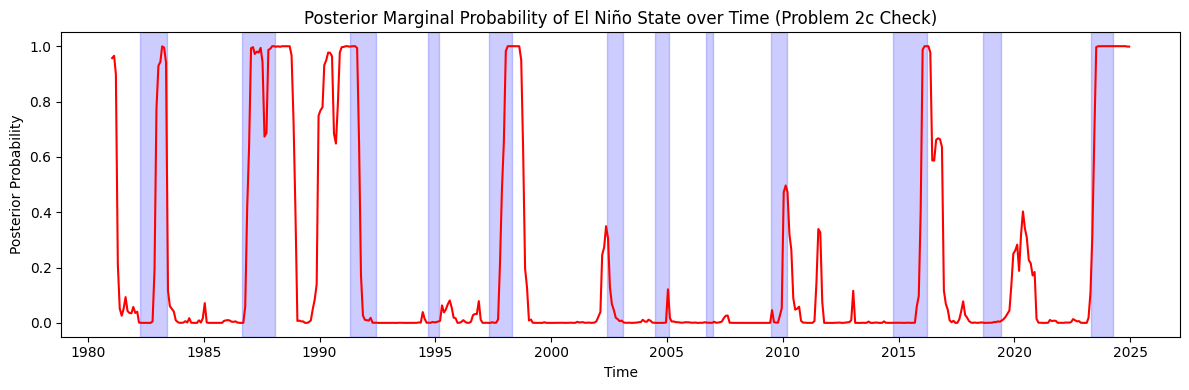

In [19]:
# One additional plot checking the fit
# Extract El Nino Posterior
el_nino_posterior = expected_states[:,2]
plt.figure(figsize=(12, 4))
plt.plot(dates, el_nino_posterior, label="Posterior P(El Niño state)", color='red')

# shading El Nino periods
for start, end in NOAA_EL_NINO_PERIODS:
    plt.axvspan(start, end, color='blue', alpha=0.2, label="NOAA El Niño period")

plt.xlabel("Time")
plt.ylabel("Posterior Probability")
plt.title("Posterior Marginal Probability of El Niño State over Time (Problem 2c Check)")
plt.tight_layout()
plt.show()

### Part 2d: Model Selection

One of the key hyperparameters to specify when fitting an HMM is the number of states, $K$. There are several strategies for choosing $K$. Here we will use cross-validation.

1. Hold out the observations for years 1983, 1988, 1992, 1999, 2004, 2010, 2015, 2020, and 2022 using the mask vector provided below. The mask is a vector $m_{1:T}$ that is zero for all time points in those years and one otherwise.

2. Fit a Gaussian HMM with $K=1,2,\ldots, 10$ states using your code above, but now provide the mask so that the model is fit based on only the training data. Remember the EM can get stuck in local optima, so fit the model several times from random initializations and keep the best model fit.

3. For each value of $K$, evaluate the **log predictive likelihood** of the held-out data under the best fitting model. You can do this by computing
   \begin{align*}
   \log p(\mathbf{r}_{\mathsf{test}} \mid \mathbf{r}_{\mathsf{train}}; \hat{\theta}) =
   \log p(\mathbf{r}; \hat{\theta}) - \log p(\mathbf{r}_{\mathsf{train}}; \hat{\theta})
   \end{align*}
   where $\mathbf{r}_{\mathsf{train}} = \{r_t: m_t=1\}$ denotes the subset of training data, $\mathbf{r}_{\mathsf{test}} = \{r_t: m_t=0\}$ denotes the held-out test data, and $\hat{\theta}$ denotes the parameters estimated with EM from the best random initialization. You can compute these marginal likelihoods by calling the `e_step` function with the appropriate mask.

4. Discuss your findings. How many discrete states would your recommend? Visualize the states of the best-fitting model with the chosen value of $K$. Can you interpret the states?


In [20]:
# We provide the followign mask
heldout_years = torch.tensor([1983, 1988, 1992, 1999, 2004, 2010, 2015, 2020, 2022])
mask = torch.tensor([date.astype(datetime).year not in heldout_years for date in dates], dtype=bool)

In [21]:
# YOUR CODE HERE
# Part 1 (the mask) was already provided

# Storing Results. lls aka log likelihoods
predictive_lls = []
best_models = {}

# for K in 1, 2, ..., 10:
for K in range(1, 11):
  best_train_ll = float('-inf')
  best_model = None
  # Fit the model several times from random initialization
  # This is item 2: keeping the best model fit
  for run in range(5):
    initial_probs = torch.ones(K) / K
    # constructing the transition matrix for this K
    alpha = 11/12
    transition_matrix = torch.full((K, K), (1 - alpha) / (K - 1) if K > 1 else 0.0)
    if K > 1:
      transition_matrix.fill_diagonal_(alpha)
    else:
      transition_matrix = torch.ones(1, 1)
    # initialize HMM
    model = GaussianHMM(num_states=K, initial_probs=initial_probs, transition_matrix=transition_matrix)
    # fit the model (to compare the training lls)
    lls, _ = model.fit(r, mask=mask, num_iters=50, verbose=False)
    train_ll = lls[-1]
    if train_ll > best_train_ll:
      best_train_ll = train_ll
      best_model = model
  # now, the best_model is the model with the best random initialization
  # want to get the log predictive likelihood
  # This is item 3: getting the ll from e_step
  _, full_ll = best_model.e_step(r, mask=torch.ones_like(mask, dtype=bool)) # NO MASK
  _, train_ll = best_model.e_step(r, mask=mask)
  pred_ll = full_ll - train_ll
  # store ther results
  predictive_lls.append(pred_ll.item())
  best_models[K] = best_model
  # printing results
  print(f"K={K}: Train LL = {train_ll.item():.2f}, Full LL = {full_ll.item():.2f}, Predictive LL = {pred_ll.item():.2f}")

K=1: Train LL = 72.84, Full LL = 102.77, Predictive LL = 29.93
K=2: Train LL = 121.71, Full LL = 158.32, Predictive LL = 36.61
K=3: Train LL = 117.96, Full LL = 151.06, Predictive LL = 33.10
K=4: Train LL = 203.55, Full LL = 255.56, Predictive LL = 52.02
K=5: Train LL = 211.40, Full LL = 262.85, Predictive LL = 51.45
K=6: Train LL = 202.92, Full LL = 250.05, Predictive LL = 47.13
K=7: Train LL = 211.17, Full LL = 258.19, Predictive LL = 47.03
K=8: Train LL = 203.60, Full LL = 250.14, Predictive LL = 46.55
K=9: Train LL = 207.77, Full LL = 255.61, Predictive LL = 47.84
K=10: Train LL = 199.82, Full LL = 239.25, Predictive LL = 39.43


In [22]:
# Printing out Findings
best_K = max(range(1, 11), key=lambda k: predictive_lls[k - 1])
print("\nBest number of states K:", best_K)


Best number of states K: 4


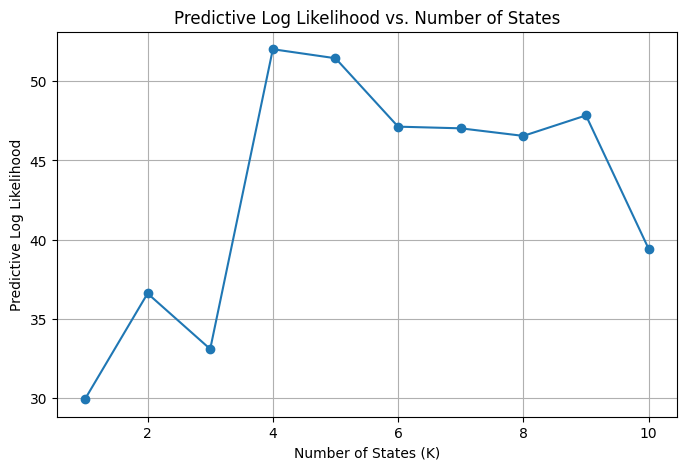

In [23]:
# Item 4: plotting the predictive log likelihood vs K
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), predictive_lls, marker='o', linestyle='-')
plt.xlabel("Number of States (K)")
plt.ylabel("Predictive Log Likelihood")
plt.title("Predictive Log Likelihood vs. Number of States")
plt.grid(True)
plt.show()

**Discussion:**

Based on the cross validation above, I would recommend having 4 states ($K = 4$). The following are the visualizations for the state. I first plot the residuals over time and the expected state assignments, imputed as the maximum over all the expected states for every given time point. I then plot the posterior probabilities for each state in the best-fitting model.

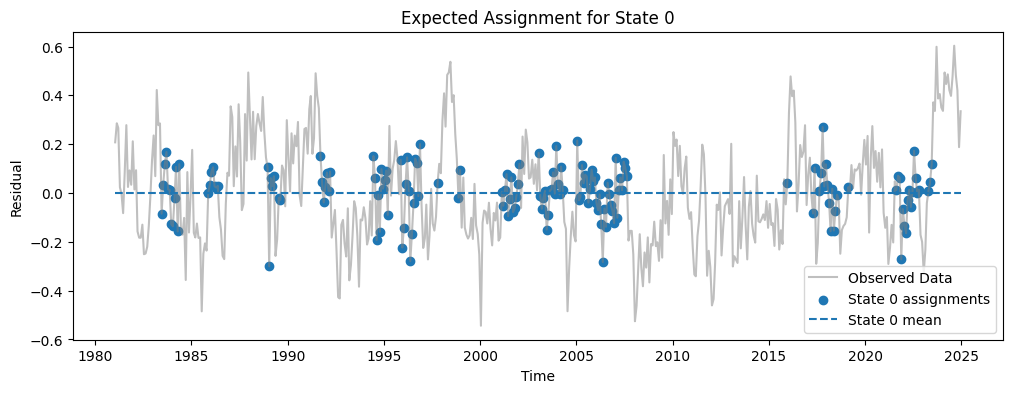

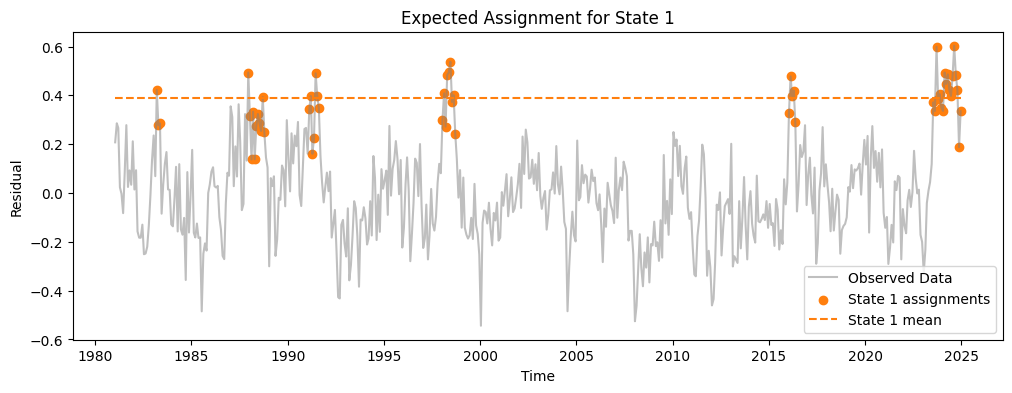

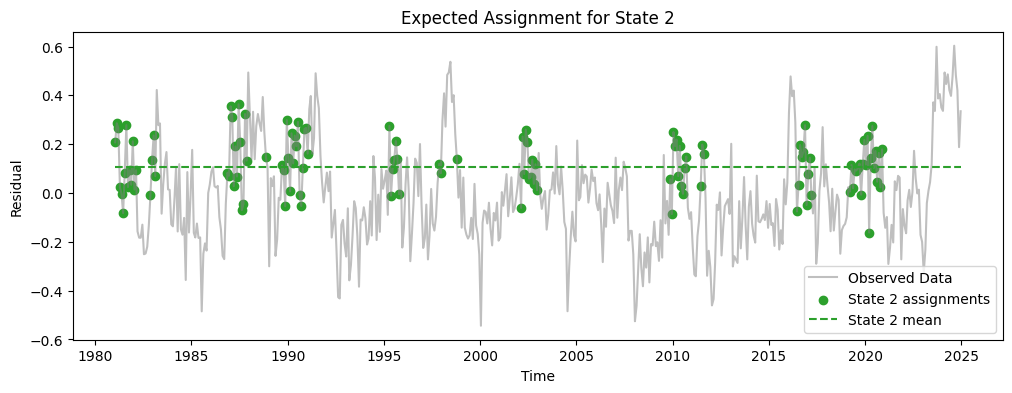

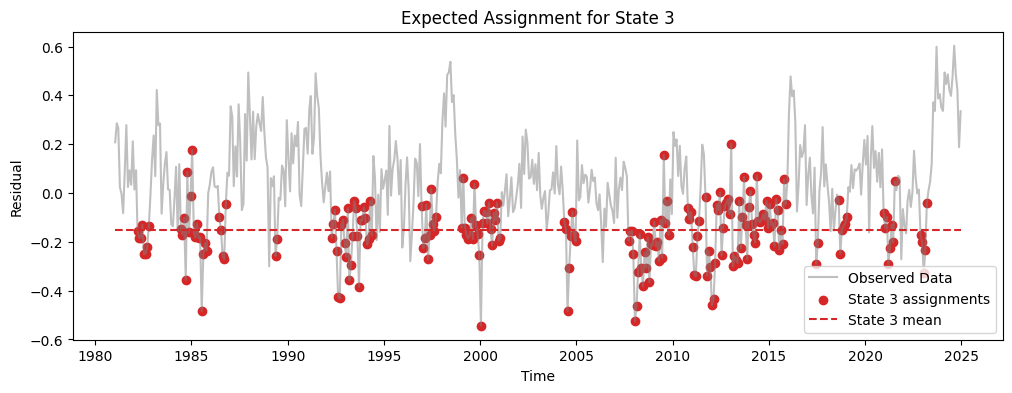

In [24]:
# Item 4: Visualize the states with the best fitting model
# Residuals Time Series and State Assigmments
best_model = best_models[best_K]
expected_states_best, _ = best_model.e_step(r, mask=torch.ones_like(mask, dtype=bool))
state_sequence = torch.argmax(expected_states_best, dim=1)

for k in range(best_K):
    plt.figure(figsize=(12, 4))
    plt.plot(dates, r, label="Observed Data", color='gray', alpha=0.5)

    # Get indices where the most likely state equals k
    indices = (state_sequence == k).nonzero(as_tuple=True)[0]

    # Plot only the data points assigned to state k
    plt.scatter([dates[i] for i in indices], r[indices],
                color=f"C{k}", label=f"State {k} assignments")

    # Overlay the state mean as a horizontal dashed line
    plt.hlines(best_model.means[k].item(), dates[0], dates[-1],
               linestyles="--", colors=f"C{k}", label=f"State {k} mean")

    plt.xlabel("Time")
    plt.ylabel("Residual")
    plt.title(f"Expected Assignment for State {k}")
    plt.legend()
    plt.show()

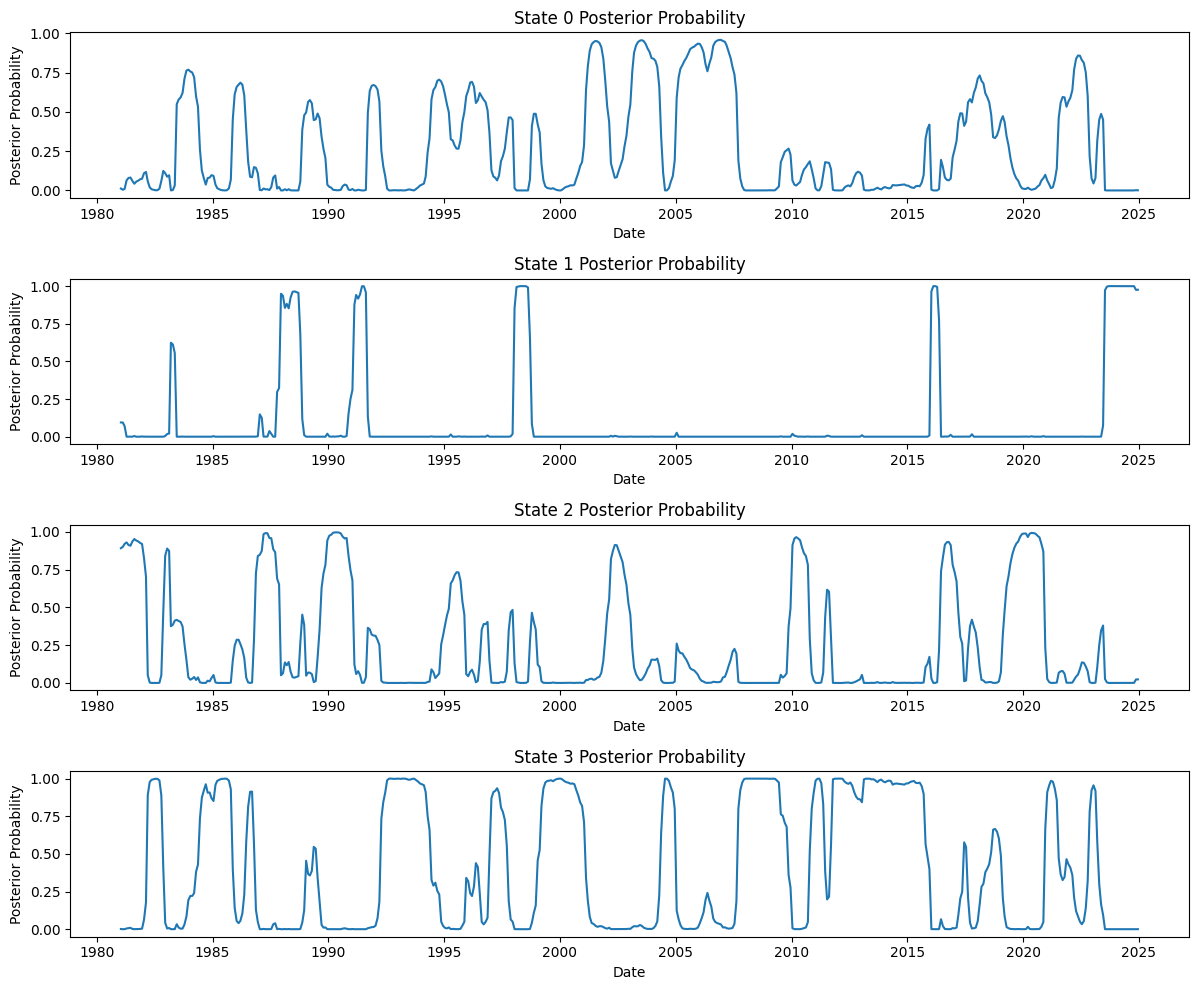

In [25]:
# Item 4: Visualize the states with the best fitting model
# Posterior Probabilities
fig, ax = plt.subplots(4, 1, figsize=(12, 10))
ax[0].plot(dates, expected_states_best[:,0], label='State 0 (Mean Zero)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Posterior Probability')
ax[0].set_title('State 0 Posterior Probability')

ax[1].plot(dates, expected_states_best[:,1], label='State 1')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Posterior Probability')
ax[1].set_title('State 1 Posterior Probability')

ax[2].plot(dates, expected_states_best[:,2], label='State 2')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Posterior Probability')
ax[2].set_title('State 2 Posterior Probability')

ax[3].plot(dates, expected_states_best[:,3], label='State 3')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Posterior Probability')
ax[3].set_title('State 3 Posterior Probability')

plt.tight_layout()

**Interpretability Discussion**

It is not very clear to interpret the four states and there are no clear geographical meanings. However, if we observe this `best_model` more closely, it seems that the combination of state 1 and state 2 forms the impression of the El Nino state, while the state 3 forms the impression of the La Nina state. In El Nino years, the global temperature tends to be warmer, corresponding to the positively higher residuals from our linear regression baseline, and conversely in La Nina years, the global temperature tends to be cooler, corresponding to the negative residuals from the baseline.

In practice, EM algorithms may break up a hidden state into several states to allow for better fit (in terms of the log likelihood), which could be the reason why in this implementation we see the best K equals 4.

## Part 3: Model Criticism and Revision

You've completed another lap of Box's Loop! We worked with real climate data, developed an HMM to infer El Niño and La Niña periods, and implemented the forward-backward and EM algorithms for state inference and parameter estimation. We even used cross-validation to select the number of states for our model. Well done!

Of course, Box's Loop wouldn't be a loop if we stopped there. In this part, let's think about ways we could improve these analyses.

### Problem 3a: Change Point Analysis

Our analyses were based on residuals from a baseline linear model that assumed a constant rate of warming over the past 40+ years. However, it's possible that the rate has changed over time as greenhouse gas emissions have varied. There are many ways to estimate nonlinear trends &mdash; one way is to use an HMM.

Recall that in our baseline model, the coefficients were $\boldsymbol{\beta} = (\beta_1, \ldots, \beta_p)$ where $\beta_1$ represented the rate of warming. Suppose the rate jumped from $\beta_1^{(1)}$ to a new value, $\beta_1^{(2)}$, at some unknown time between 1981 and 2024. Describe how you could use an HMM to infer the time of the change point. Define the model mathematically and specify any relevant constraints on the parameters. You should also account for monthly effects, as in the baseline model.

_You do not have to fit the model, only specify it and justify your reasoning._

_Your answer here_

**Answer 3a: Change Point Analysis**

Let $z_t \in \{1, 2\}$ denote a **discrete latent state** at time $t$. For the scope of this question, we will model the temperature itself as _conditionally independent_ given the latent states using a linear regression model,
\begin{align*}
y_t &= \beta_1^{(k)} t + \boldsymbol{\beta_m}^\top \mathbf{x}^m_t + \epsilon_t \ \mid z_t = k
\end{align*}
where $\epsilon_t \sim \mathrm{N}(0, \sigma^2)$ denotes the independent, mean zero noise terms. Note that we have here assumed homogenous variance - one could also model  $\epsilon_t \sim \mathrm{N}(0, \sigma_{(k)}^2)$ to allow for different variance before and after the change point. The $\boldsymbol{\beta_m}$ here are the coefficients associated with $\mathbf{x}^m_t := (\mathbb{I}[d_t = 1], \ldots, \mathbb{I}[d_t=12]) \in \mathbb{R}^{12}$, the monthly effects. With the property of normal random variables, we can write:
\begin{align*}
y_t \mid z_t = k &\sim \mathrm{N}(\beta_1^{(k)} t + \boldsymbol{\beta_m}^\top \mathbf{x}^m_t, \sigma^2) \
\end{align*}
**Note that $z_t \in \{1, 2\}$ represents the time series before and after the change point.** We want to detect the time when the latent state changes, i.e., when the rate of warming changes. Thus, we can model the latent states as a Markov process,
\begin{align*}
\Pr(z_{t+1}=j \mid z_t =i) = p_{ij},
\end{align*}
where $p_{ij}$ are the elements of the transition matrix for $i, j \in \{1, 2\}$:
\begin{align*}
\mathbf{P} =
\begin{bmatrix}
\alpha  & 1-\alpha \\
0 & 1
\end{bmatrix}
\end{align*}
Observe this transition matrix. State 2 is the absoprtion state: once the Markov Chain hits state 2, it stays. This means that the change point only happens once: we assume that the rate of warming stays the same for the period either before or after the change point.

Additionally, we want to make sure that the change point happens rather infrequently to capture a real change in estimated magnitude. Discussion of this parameter is very similar to Problem 1c and 1d. As such, we must set $\alpha > 0.5$ to allow for autocorrelation, and ideally set $\alpha$ to a higher value such as 0.9 to best model the change point. Mathematically, $\alpha \in (0.5, 1)$ and reasonable choice of the hyperparameter $\alpha$ would be closer to 1 than 0.5.

Finally, we assume
\begin{align*}
P(z_1 = 1) = 1
\end{align*}
which means that we always start at the state before the change point.


The parameters of the model are $\Theta = (\beta_1^{(1)}, \beta_1^{(2)},\boldsymbol{\beta_m}, \sigma^2, \alpha)$. Similarly, our goal would be to estimate the parameters and infer the posterior marginal distributions of the latent states. Note that in actual fitting we might want to set $\alpha$ as a hyperparameter to simplify the calculations in the M-step, similar to what we did in Problem 2.

### Problem 3b: Spatiotemporal Analysis

The NOAA data has rich spatiotemporal structure, but we ignored the spatial component and just modeled the global mean temperature! It's possible that some parts of the globe are warming faster than others. Some parts might even be cooling over time. Likewise, anomalies like El Niño could affect the temperature in some regions more than others.

Describe, mathematically, how you would model the full spatiotemporal dataset. What challenges can you anticipate, and how would you address them?

_You do not have to fit the model, only specify it and justify your reasoning._

_Your answer here_

**Answer 3b: Discussion on Spatiotemporal Analysis**

**Challenges I can anticipate:** The spatial component is very rich, and it can be difficult to fit the model directly with such a high dimensional structure.

**Addressing the challenge:** We can first run PCA on the spatio structure to get the first few principal components. Mathematically, we want to reduce the temperature tensor of shape $T \times D_{\mathsf{lat}} \times D_{\mathsf{lon}}$ to a shape of $T \times S$ where $S$ is the number of principle components we choose. (We usually can do this using a scree plot and pick out a few PCs. In class, we have seen that the first PC in this setting usually corresponds to the north and south hemisphere, and the second PC corresponds to the arctic and antarctic regions and the desert regions, and so on.) Then, we can start fitting the model using the $T \times S$ tensor, and for each timestamp the response vector would look like a vector with length $S. The remaining model would look very similar to the Gaussian HMM we have specified in this homework. This allows us to model the full spatiotemporal dataset without dealing with too many dimensions in the spatial components, while offering relatively interpretable results.

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.